In [1]:
from Basefolder import basefolder
import time
import numpy as np
import pandas as pd
from Finder_1d import Finder_1d
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import seaborn as sns
from sklearn.cluster import DBSCAN
from Clustering_CAML import Clustering_CAML
import h5py
from DbscanLoop import DbscanLoop
from sklearn.neighbors import NearestNeighbors
import pickle
import scipy.stats as stats
import json
import os.path

from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import PlotScatter
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import LoadPoints
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import FilterPoints
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetLineOfOptima
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetLineOfOptimaUnique
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetClusterDistribution
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetClusterSizesAlongOptima
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import AnalyseClusterSizes
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import PlotDistribution

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
basefolder = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/';

### Possible parameter sets

In [3]:
parameters_TTX = {'mainfolder'    :'ProteinData_ttx_1hr_2/',\
                  'image_filename':'AHA_2_MMStack_Pos0.ome_locs_render_driftcor_filter_render_pix0.02X6f20_X',\
                  'signal_window' :[40000,45000,40000,45000],\
                  'noise_window'  :[50000,60000,40000,50000],\
                  'datascale'     :158,
                  'algo'          :'DbscanLoop',\
                  'analysis_name' :'dataWindow_5'};

parameters_Mike = {'mainfolder'    :'MikeData/',\
                   'image_filename' :'EGFR-P1-ATTO655_cell_2_MMImages.ome_locs_render_al_linked1sigma_X',\
                   'signal_window'  :[50,60,50,60],\
                   'noise_window'   :[50,100,100,150],\
                   'algo'           :'DbscanLoop',\
                   'analysis_name'  :'dataWindow_1'};

# Parameters

In [4]:
loadSaveParameters = 'load';

In [5]:
if(loadSaveParameters=='load'):
    parameterfile = 'ProteinData_ttx_1hr_2/Analysis_dataWindow_3/dataWindow_3_parameters';
#    parameterfile = 'MikeData/Analysis_dataWindow_1/dataWindow_1_parameters';    
    
    
    with open(basefolder+parameterfile+'.json') as f:
        parameters = json.load(f);
        
    if(not ('datascale' in parameters.keys())):
        parameters['datascale'] = 1;
    
elif(loadSaveParameters=='save'):
    
    parameters                   = parameters_TTX;    
    parameters['outputfolder']   = parameters['mainfolder'] + 'Analysis_'+parameters['analysis_name']+'/';    
    parameters['save_name']      = parameters['outputfolder']+parameters['analysis_name'];
    
    parameterfile   = basefolder+parameters['save_name']+'_parameters.json';
        
    if(os.path.isfile(parameterfile)):
        
        with open(parameterfile) as f:
            parameters_read = json.load(f)
        
        if(parameters_read == parameters):
            print('File exists with equal parameters');
        else:
            print('File exists with different parameters. File not saved.');
    else:
        
        if not os.path.exists((basefolder+parameters['outputfolder'])):
            os.makedirs((basefolder+parameters['outputfolder']))
                
        with open(parameterfile, 'w') as fp:
            json.dump(parameters, fp, indent=4);
            
        print("Parameters saved under "+parameterfile);
else:
    print("ERROR: Choose load or save");

In [6]:
save_name = basefolder + parameters['save_name'];

# Load Points

In [66]:
XC_signal = LoadPoints(basefolder+parameters['mainfolder']+parameters['image_filename']+'_signal.txt',datascale=parameters['datascale']);    
XC_noise  = LoadPoints(basefolder+parameters['mainfolder']+parameters['image_filename']+'_noise.txt',datascale=parameters['datascale']);    

In [67]:
#XC_signal = LoadPoints(basefolder+parameters['mainfolder']+parameters['image_filename']+'_signal.txt',datascale=158);    
#XC_noise  = LoadPoints(basefolder+parameters['mainfolder']+parameters['image_filename']+'_noise.txt',datascale=158);    

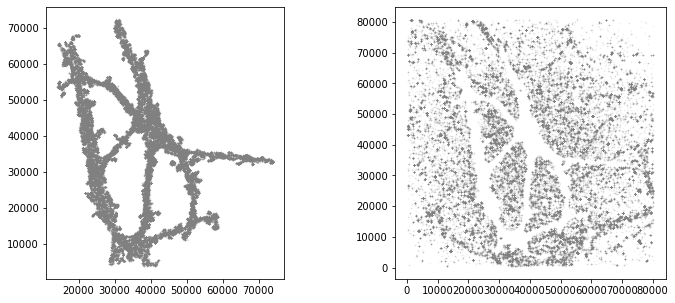

In [68]:
fig,axs = plt.subplots(1,2,figsize=(12,5));
PlotScatter(XC_signal[:,:],ax=axs[0])
PlotScatter(XC_noise[:,:],ax=axs[1])

In [69]:
XC_signal = FilterPoints(XC_signal,parameters['signal_window']);
XC_noise  = FilterPoints(XC_noise,parameters['noise_window']);

In [71]:
XC_noise_overlay = np.zeros([0,2])
xis = np.linspace(np.min(XC_noise[:,0]),np.max(XC_noise[:,0]),5);
yis = np.linspace(np.min(XC_noise[:,1]),np.max(XC_noise[:,1]),5);
for i,xl in enumerate(xis[:-1]):
    xr   = xis[i+1];

    for i,yl in enumerate(yis[:-1]):        
        yr   = yis[i+1];
        mark = (XC_noise[:,0]>=xl)&(XC_noise[:,0]<=xr);    
        mark = mark&(XC_noise[:,1]>=yl)&(XC_noise[:,1]<=yr);
        XC_noise_overlay = np.concatenate((XC_noise_overlay,XC_noise[mark,:]-[xl,yl]))
#        break;
#    break;
#    for y_i np.linspace(np.min(XC_noise[:,0]),np.max(XC_noise[:,0]),5):
XC_noise = XC_noise_overlay;

In [72]:
np.savetxt(basefolder+parameters['save_name']+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");   
np.savetxt(basefolder+parameters['save_name']+"_filtered_noise.txt",XC_noise,fmt="%f\t%f");

Plot Overview

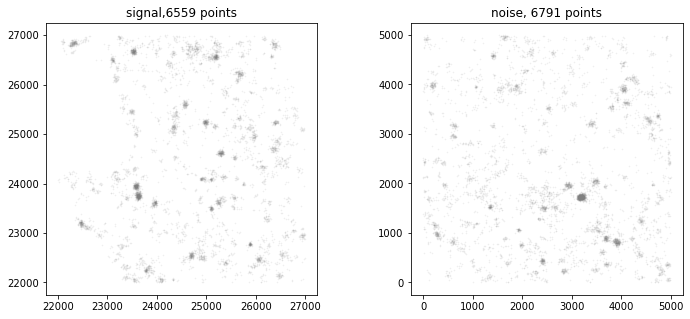

In [73]:
fig,axs = plt.subplots(1,2,figsize=(12,5));
PlotScatter(XC_signal,ax=axs[0])
PlotScatter(XC_noise,ax=axs[1])
#np.savetxt(outputfolder_R+analysis_name+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");    
axs[0].set_title('signal,'+str(len(XC_signal))+' points');
axs[1].set_title('noise, '+str(len(XC_noise))+' points');
for ax in axs:
    ax.set_aspect('equal');
#axs[1].set_xlim([50,60]);
#axs[1].set_ylim([50,60]);

plt.savefig(basefolder+parameters['save_name']+"_localizations_signal_vs_noise.pdf",bbox_inches="tight");

# Load or compute clustering

In [74]:
#labels_ref  = FD_ref.fit(XC_noise,XC_signal,skipSimilarityScore=True);

In [79]:
loadComputeClustering = "load";

In [80]:
filename = basefolder+parameters['outputfolder']+"results_"+parameters['analysis_name'];
if(loadComputeClustering == "compute"):
    FD      = Finder_1d(algo=parameters['algo']);
    labels  = FD.fit(XC_signal);    
    
    with open(filename+'_signal.pickle','wb') as handle:
        pickle.dump({'FD':FD}, handle,protocol=pickle.HIGHEST_PROTOCOL)   
    
    FD_ref      = Finder_1d(algo=parameters['algo']);
    labels_ref  = FD_ref.fit(XC_noise,XC_signal,skipSimilarityScore=True );    
    
    with open(filename+'_noise.pickle','wb') as handle:
        pickle.dump({'FD_ref':FD_ref}, handle,protocol=pickle.HIGHEST_PROTOCOL)   
    
    if(os.path.exists(filename+'.pickle')):
        os.remove(filename+'.pickle');
    #with open(filename+'.pickle','wb') as handle:
    #    pickle.dump({'FD':FD,'FD_ref':FD_ref}, handle,protocol=pickle.HIGHEST_PROTOCOL)   
elif(loadComputeClustering == "load"):
    
    if(os.path.exists(filename+'.pickle')):
        with open(filename+'.pickle', 'rb') as fr:
            FD_load = pickle.load(fr);

        FD     = FD_load['FD'];
        FD_ref = FD_load['FD_ref'];
    else:
        with open(filename+'_signal.pickle', 'rb') as fr:
            FD_load = pickle.load(fr);
        FD     = FD_load['FD'];        

        with open(filename+'_noise.pickle', 'rb') as fr:
            FD_load = pickle.load(fr);        
        FD_ref     = FD_load['FD_ref'];
    
    print("Loaded Clustering results from "+filename+'.pickle');
else:
    print("ERROR");

Loaded Clustering results from /Users/andreas/Documents/NoiseRecognizer_WorkingVersion/ProteinData_ttx_1hr_2/Analysis_dataWindow_3/results_dataWindow_3.pickle


In [81]:
df1     = FD.phasespace[['sigma', 'threshold','similarityScore','no_clusters']];
df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore','no_clusters']];

df1['similarityScore_ref']       = df1_ref['similarityScore'];
df1['similarityScore_ref_ratio'] = (df1_ref['similarityScore'])/(df1['similarityScore']);

df1['no_clusters_ref']       = df1_ref['no_clusters'];
df1['no_clusters_ref_ratio'] = (df1_ref['no_clusters'])/(df1['no_clusters']);

df_opt_sim = GetLineOfOptima(df1,'similarityScore_ref','similarityScore',15);
df_opt_cl  = GetLineOfOptima(df1,'no_clusters_ref','no_clusters',15);

# Analysis
## Heatmaps Similiarity Score and Number of Clusters

ValueError: zero-size array to reduction operation fmin which has no identity

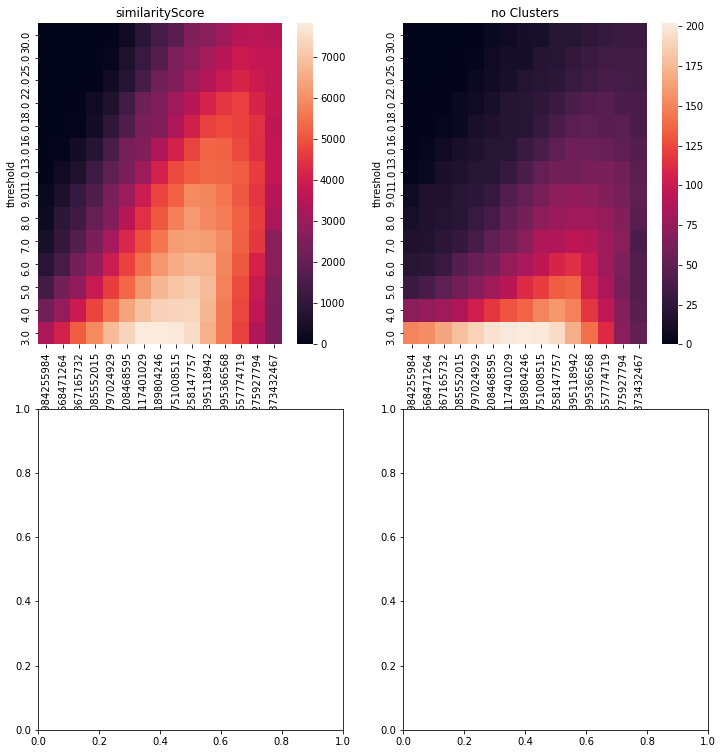

In [82]:
fig,axs = plt.subplots(2,2,figsize=(12,13));


heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0,0]);
ax.invert_yaxis()
ax.set_title('similarityScore');

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0,1]);
ax.invert_yaxis()
ax.set_title('no Clusters');

heatmap1_data = pd.pivot_table(df1_ref, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1,0]);
ax.invert_yaxis()
ax.set_title('similarityScore Ref');

heatmap1_data = pd.pivot_table(df1_ref, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1,1]);
ax.invert_yaxis()
ax.set_title('no Clusters Ref');

fig.tight_layout();
plt.savefig(save_name+"_PhaseSpaces.pdf",bbox_inches="tight");

## Analyse Line Of Optima of signal

In [83]:
df_opt_th     = GetLineOfOptima(df1,'threshold','similarityScore')
df_opt_th_ncl = GetLineOfOptima(df1,'threshold','no_clusters')

df_clusterSizes     = GetClusterSizesAlongOptima(FD,df_opt_th);
df_clusterSizes_ref = GetClusterSizesAlongOptima(FD_ref,df_opt_th);

df_clusterSizes['type'] = 'signal';
df_clusterSizes_ref['type'] = 'noise';
df_clusterSizes_all = df_clusterSizes.append(df_clusterSizes_ref, ignore_index=True);

ValueError: Axis limits cannot be NaN or Inf

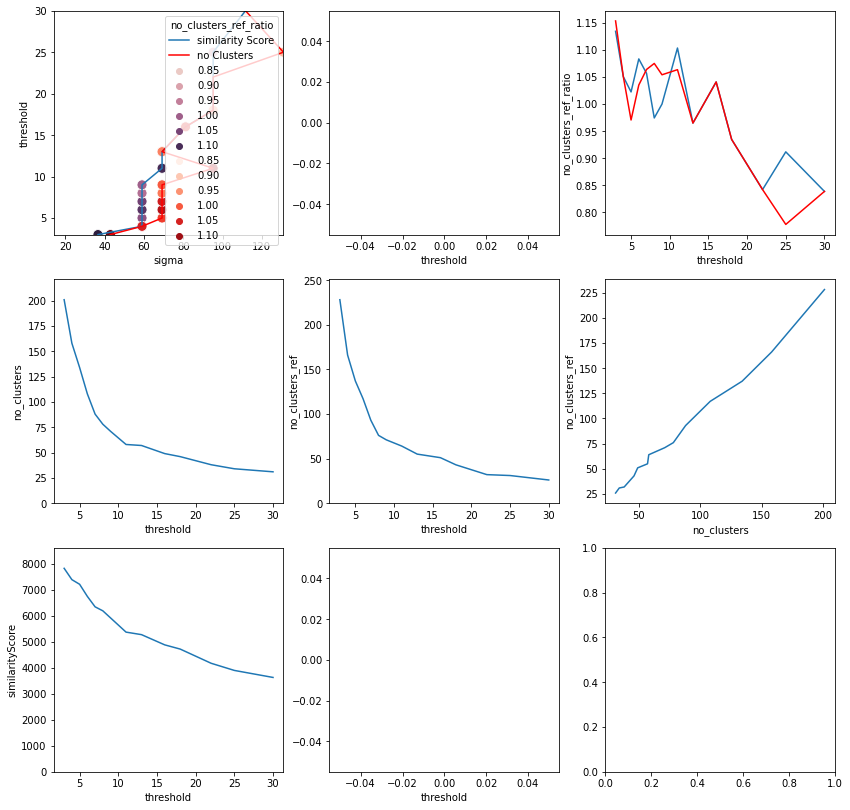

In [84]:
fig,axs = plt.subplots(3,3,figsize=(14,14));

ax = axs[0,0];
ax.plot(df_opt_th['sigma'],df_opt_th['threshold'],label='similarity Score');
sns.scatterplot(x=df_opt_th['sigma'],y=df_opt_th['threshold'],hue=df_opt_th['no_clusters_ref_ratio'],s=100,ax=ax);

ax.plot(df_opt_th_ncl['sigma'],df_opt_th_ncl['threshold'],'r',label='no Clusters');
sns.scatterplot(x=df_opt_th_ncl['sigma'],y=df_opt_th['threshold'],hue=df_opt_th['no_clusters_ref_ratio'],\
                s=100,ax=ax,palette='Reds');

ax.set_xlim(np.min(df1['sigma']),np.max(df1['sigma']))
ax.set_ylim(np.min(df1['threshold']),np.max(df1['threshold']))

ax = axs[0,1];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore_ref_ratio',ax=ax);
sns.lineplot(data=df_opt_th_ncl,x='threshold',y='similarityScore_ref_ratio',ax=ax,color='r');

ax = axs[0,2];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters_ref_ratio',ax=ax);
sns.lineplot(data=df_opt_th_ncl,x='threshold',y='no_clusters_ref_ratio',ax=ax,color='r');

ax = axs[1,0];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['no_clusters']));

ax = axs[1,1];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters_ref',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['no_clusters_ref']));

ax = axs[1,2];
sns.lineplot(data=df_opt_th,x='no_clusters',y='no_clusters_ref',ax=ax);

ax = axs[2,0];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['similarityScore']));

ax = axs[2,1];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore_ref',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['similarityScore_ref']));

ax = axs[2,2];
sns.lineplot(data=df_opt_th,x='similarityScore',y='similarityScore_ref',ax=ax);

plt.savefig(save_name+"_Analysis_alongLineOfOptima.pdf",bbox_inches="tight");

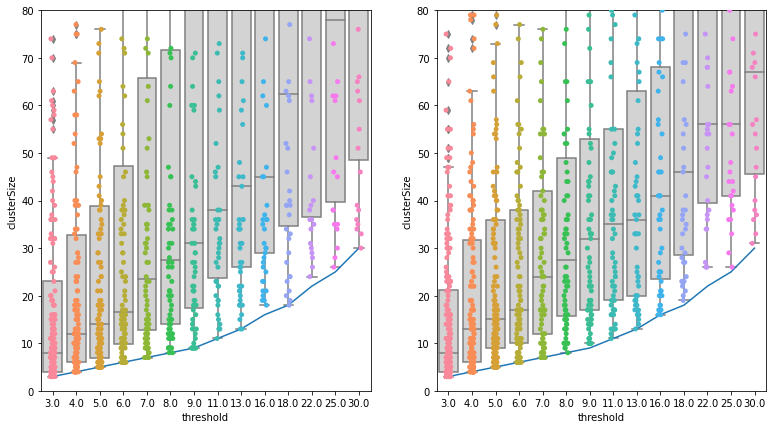

In [85]:
PlotDistribution(df_clusterSizes,df_clusterSizes_ref,save_name+"_clusterDistribution_alongLineOfOptima_signal.pdf");

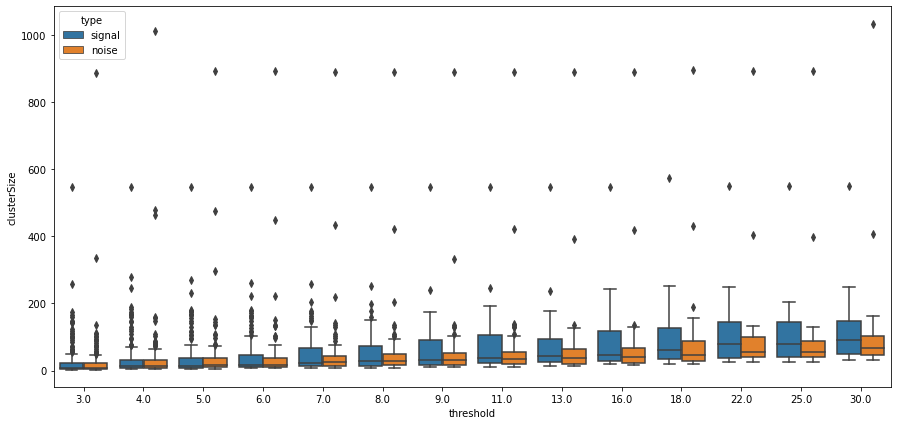

In [86]:
fig,axs = plt.subplots(1,1,figsize=(15,7));
sns.boxplot(data=df_clusterSizes_all,y='clusterSize',x='threshold',hue='type');

## Exploration

In [91]:
def GetOptimalT(df_clusterSizes_all,threshold):
    df_signal = df_clusterSizes_all[(df_clusterSizes_all['threshold']==threshold)&\
                    (df_clusterSizes_all['type']=='signal')];
    df_noise  = df_clusterSizes_all[(df_clusterSizes_all['threshold']==threshold)&\
                    (df_clusterSizes_all['type']=='noise')];
    #ts = np.linspace(10,df_signal['clusterSize'].max(),500);
    ts = [];
    signal_vs_noise_probability = [];
    for t in np.unique(df_signal['clusterSize']):
        no_clusters_over_t_noise  = np.sum(df_noise['clusterSize']>t)/len(df_noise['clusterSize']);
        no_clusters_over_t_signal = np.sum(df_signal['clusterSize']>t)/len(df_signal['clusterSize']);
        if(no_clusters_over_t_signal+no_clusters_over_t_noise > 0):
            signal_vs_noise_probability.append(no_clusters_over_t_signal/(no_clusters_over_t_noise+no_clusters_over_t_signal));
            ts.append(t);

    T = ts[np.argmax(signal_vs_noise_probability)];
    plt.plot(ts,signal_vs_noise_probability);
    print(signal_vs_noise_probability);
    print(ts);    
    print(T);
    return T;

[0.5261121856866537, 0.5154911008569545, 0.527222605099931, 0.5343567251461989, 0.5289653427776373, 0.5504587155963303, 0.5441860465116278, 0.5451476793248945, 0.5385273972602739, 0.5393654524089307, 0.5330464186904396, 0.5256089943785134, 0.5261121856866537, 0.5181907571288101, 0.51, 0.51, 0.51, 0.5206295193534666, 0.5448211797491872, 0.5886673662119621, 0.5773584905660377, 0.5811965811965811, 0.6872340425531914, 0.7007633587786259, 0.6886417791898332, 0.7040552200172562, 0.6904332129963898, 0.7083333333333333, 0.7301762114537446, 0.7141190198366395, 0.6960297766749379, 0.8388157894736842, 0.7846153846153846, 0.7574257425742574, 0.7223796033994334, 0.6754966887417219, 0.6095617529880478, 0.51, 0.3422818791946309, 0.0]
[18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 39, 45, 47, 60, 62, 65, 74, 89, 94, 99, 101, 105, 110, 118, 128, 140, 147, 152, 171, 173, 179, 189, 242, 548]
140


140

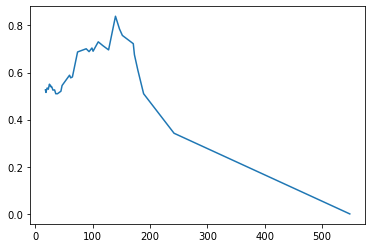

In [94]:
GetOptimalT(df_clusterSizes_all,16)

In [95]:
def RemoveLabelsSmallerT(labels_input,df,T):
    #labels_signal = FD.phasespace.loc[idx_,'labels'];
    labels           = labels_input.copy();
    labels_to_remove = df.loc[df['clusterSize']<T,'labels'];
    for l in np.unique(labels_to_remove):
        labels[labels == l] = -1;
    return labels;
    
def FindAndPlot(threshold,df_clusterSizes_all,df_opt_th):
    #
    df_signal = df_clusterSizes_all[(df_clusterSizes_all['threshold']==threshold)*\
                    (df_clusterSizes_all['type']=='signal')];
    df_noise  = df_clusterSizes_all[(df_clusterSizes_all['threshold']==threshold)*\
                    (df_clusterSizes_all['type']=='noise')];
    
    T = GetOptimalT(df_clusterSizes_all,threshold);
    #*******************************************************
    # Get labels of clusters larger than T
    idx_ = int(df_opt_th.loc[df_opt_th['threshold']==threshold,'idx'])
    labels_signal = RemoveLabelsSmallerT(FD.phasespace.loc[idx_,'labels'],df_signal,T);
    labels_noise  = RemoveLabelsSmallerT(FD_ref.phasespace.loc[idx_,'labels'],df_noise,T);        
    #*******************************************************
    
    fig,axs = plt.subplots(1,2,figsize=(13,8)); 
    PlotScatter(XC_signal,labels_signal,ax=axs[0])
    PlotScatter(XC_noise,labels_noise,ax=axs[1])
    axs[0].set_title('signal for clusters with size > '+str(T));
    axs[1].set_title('noise for clusters with size > '+str(T));
    
    #axs[1].set_ylim([57500,62500]);
    #axs[1].set_xlim([55000,60000]);
    plt.savefig(save_name+"_OptimalClustering_split_threshold_"+str(threshold)+".pdf",bbox_inches="tight");

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.4899962563953246, 0.4911552431718477, 0.48039944757250613, 0.4844378086596991, 0.4933198890849508, 0.5029075596551033, 0.5079318448883666, 0.5037037037037037, 0.5194498354569235, 0.5092013578702878, 0.5048180372345402, 0.5033112582781457, 0.5055607525205279, 0.5039230854238037, 0.5064889512451771, 0.4969726325986921, 0.4916034332628436, 0.5037037037037037, 0.526534571151448, 0.5420505200594353, 0.5422802489752543, 0.5369374904008601, 0.5606557377049181, 0.54421768707483, 0.5582972311169712, 0.5530624620982414, 0.5537052456286429, 0.5707974375966424, 0.5634688833969895, 0.5826545280306661, 0.5844703547506822, 0.5764854614412136, 0.5781741867785939, 0.6049528301886793, 0.6482939632545932, 0.6393001345895021, 0.6298342541436464, 0.6349436977842353, 0.6245797534553605, 0.6136101499423299, 0.601980198019802, 0.6237580993520518, 0.6298342541436465, 0.6585117227319063, 0.6940639269406392, 0.7085146053449347, 0.7257844474761256, 0.7467876039304611, 0.7313552526062551, 0.7572463768115942, 0.

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.5123456790123456, 0.5258419473157719, 0.5081100879028883, 0.5033381551129409, 0.5123456790123456, 0.49952486537852386, 0.4958587915818058, 0.5004411764705883, 0.4873300370828183, 0.49556347955883573, 0.5123456790123457, 0.5085878748491319, 0.5007181844297616, 0.5081456884922694, 0.4993017509936621, 0.49858324832823303, 0.4889684648261523, 0.4971920628977911, 0.49150360453141095, 0.50123524567664, 0.5009825940482876, 0.48907732106927276, 0.5123456790123457, 0.5123456790123457, 0.5191885038038884, 0.526612618963694, 0.5361127422196125, 0.5377220480668756, 0.5781286278151846, 0.5806996381182147, 0.5952868852459017, 0.5988776055585249, 0.607080163838502, 0.6270066100094429, 0.617000646412411, 0.6064430421786782, 0.6177893561592854, 0.6056067588325653, 0.7027281279397931, 0.6906510034263338, 0.7369589345172032, 0.7242582897033158, 0.7102689486552567, 0.6947842884739214, 0.6775510204081633, 0.6980122324159022, 0.724258289703316, 0.7591463414634146, 0.7369589345172032, 0.7102689486552567, 

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.4972012056344959, 0.48300405773963945, 0.4861116089029067, 0.4800135628979392, 0.4703768763973171, 0.4737246531483458, 0.46800849413719886, 0.4792071511853867, 0.47812452582064646, 0.48034424139396514, 0.49390557939914165, 0.4935333372704187, 0.501261670451678, 0.4964434304120252, 0.49610027855153205, 0.49573020697640763, 0.5055350553505535, 0.5055350553505535, 0.5055350553505535, 0.4944225721784777, 0.4882892057026477, 0.5117062949804136, 0.5055350553505534, 0.5121999212908304, 0.512382492671586, 0.5272610647851186, 0.5285973672265093, 0.5211527377521614, 0.5301088270858525, 0.5399872854418309, 0.5509383378016086, 0.5425372115253312, 0.5654481132075472, 0.5586574654956085, 0.573605761179032, 0.605301914580265, 0.610540592908351, 0.5999203821656051, 0.6228620913617666, 0.6301747930082796, 0.6181429589171218, 0.6479243300052548, 0.6588401697312588, 0.6450853443201884, 0.6571794051806844, 0.6715686274509804, 0.6550202280250093, 0.6367157242447714, 0.6922370234267341, 0.718782791185729

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.48997594226142743, 0.49056603773584906, 0.49801849405548215, 0.4828060522696011, 0.49529935675408215, 0.5036649214659685, 0.49650349650349657, 0.4988713318284424, 0.49326805385556916, 0.4919820397690827, 0.48148148148148157, 0.4927113702623907, 0.4922048997772829, 0.4961832061068703, 0.49571984435797667, 0.5048543689320388, 0.5095913261050875, 0.5091383812010444, 0.5035211267605634, 0.5086442220200182, 0.5081029551954243, 0.5138339920948617, 0.52, 0.5268346111719606, 0.527027027027027, 0.5346650998824912, 0.5351089588377724, 0.5366178428761652, 0.5371900826446281, 0.5471698113207547, 0.558282208588957, 0.5707317073170731, 0.5971731448763251, 0.6007393715341959, 0.6341463414634146, 0.6402569593147751, 0.6299559471365639, 0.6546762589928058, 0.6435643564356435, 0.6517150395778364, 0.6610169491525424, 0.6717325227963525, 0.6582278481012658, 0.6989247311827956, 0.6842105263157894, 0.6679841897233202, 0.6499999999999999, 0.7486910994764397, 0.7303370786516853, 0.7647058823529411, 0.68421

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.5078623593657478, 0.5169148425169834, 0.5105028178291737, 0.5138121546961326, 0.5138121546961326, 0.5100548446069469, 0.4941207211915339, 0.4853338132085658, 0.4713722545522809, 0.46987951807228917, 0.4949389543984139, 0.49457562220804085, 0.494198026244442, 0.49865951742627346, 0.4983468247634249, 0.5031757233592096, 0.4920634920634921, 0.5080675898869267, 0.5138121546961326, 0.5201342281879194, 0.5202983789987089, 0.5071481208548269, 0.5138121546961326, 0.5284948855333658, 0.5061224489795918, 0.5575323921871979, 0.5322976287816844, 0.564650326062514, 0.5787458113930111, 0.5816862646985239, 0.5717213114754097, 0.6345298131118363, 0.6241610738255033, 0.6490528414755733, 0.6378600823045267, 0.6460694698354661, 0.6662452591656132, 0.6788321167883212, 0.6936847339632023, 0.7114754098360656, 0.696027633851468, 0.6788321167883211, 0.6595744680851063, 0.6378600823045267, 0.7602179836512263, 0.7380952380952381, 0.7114754098360656, 0.6788321167883211, 0.6378600823045267, 0.5849056603773585,

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.4968174780664029, 0.47942951179374654, 0.48593350383631717, 0.4738348323793949, 0.48111587982832615, 0.4806924101198402, 0.48, 0.4842510218802597, 0.4935064935064935, 0.49845679012345684, 0.49855680923642093, 0.49350649350649356, 0.4826418289585097, 0.49925350851000305, 0.5115842204132749, 0.5125000000000001, 0.5, 0.49350649350649345, 0.500355871886121, 0.49350649350649356, 0.5173267326732673, 0.5017035775127768, 0.5198358413132694, 0.5120307988450433, 0.5029411764705882, 0.5370265686828717, 0.5390070921985817, 0.5990404386566142, 0.6049204052098408, 0.6303317535545023, 0.6188925081433224, 0.6067226890756303, 0.6608695652173914, 0.6479438314944835, 0.6608695652173913, 0.7089552238805971, 0.6945169712793734, 0.7169811320754716, 0.7004608294930876, 0.6818923327895596, 0.6608695652173914, 0.6867469879518072, 0.6945169712793734, 0.6608695652173914, 0.6188925081433224, 0.5650557620817844, 0.49350649350649356, 0.3937823834196891, 0.32758620689655177, 0.0]
[8, 9, 11, 12, 13, 14, 15, 16, 17

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.46616541353383456, 0.4803149606299213, 0.4838709677419355, 0.4836065573770492, 0.4789915966386555, 0.4869565217391304, 0.4910714285714285, 0.4954128440366973, 0.5047619047619047, 0.5049504950495051, 0.5104166666666666, 0.5, 0.5057471264367815, 0.5119047619047619, 0.5121951219512195, 0.5125, 0.5064935064935066, 0.5, 0.49295774647887325, 0.515625, 0.5, 0.5, 0.5, 0.5294117647058824, 0.5416666666666667, 0.5434782608695652, 0.6, 0.5945945945945946, 0.5833333333333334, 0.6060606060606061, 0.59375, 0.6666666666666666, 0.6538461538461539, 0.64, 0.7142857142857143, 0.7000000000000001, 0.7058823529411764, 0.6875, 0.6666666666666667, 0.6428571428571428, 0.7272727272727272, 0.7777777777777778, 0.7142857142857143, 0.6666666666666667, 0.6, 0.5, 0.33333333333333337, 0.0]
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 29, 31, 34, 35, 36, 38, 43, 44, 45, 59, 60, 64, 70, 71, 88, 92, 93, 104, 106, 109, 115, 119, 125, 135, 146, 147, 148, 155, 175, 240, 546]
146


/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.49958915365653245, 0.5067448680351906, 0.5064198268139743, 0.5016581248115767, 0.5103189493433395, 0.5296259516716318, 0.529837875129355, 0.5299506694855531, 0.5359136583550428, 0.5304548959136469, 0.5494685200327065, 0.550104821802935, 0.5507745266781412, 0.551480335837384, 0.5450470640968176, 0.5316105214582373, 0.5318138651471985, 0.5396825396825397, 0.532258064516129, 0.5245901639344263, 0.5336509827278142, 0.5643370346178969, 0.5892351274787535, 0.5797101449275363, 0.6090404440919905, 0.6285226302305722, 0.6180860403863038, 0.6070460704607047, 0.6293018682399214, 0.6172588832487309, 0.6881720430107527, 0.675776397515528, 0.6881720430107526, 0.7027818448023426, 0.6881720430107526, 0.7050847457627119, 0.6881720430107527, 0.6692015209125475, 0.6477732793522267, 0.7128712871287128, 0.7943262411347517, 0.7680000000000001, 0.7339449541284404, 0.6881720430107526, 0.6233766233766235, 0.5245901639344263, 0.35555555555555557, 0.0]
[11, 13, 14, 15, 16, 18, 19, 20, 22, 23, 26, 27, 28, 29, 

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.495657873177126, 0.5005055611729019, 0.5158379047956114, 0.5230125523012552, 0.5295735900962861, 0.5428747686613202, 0.5322953923837576, 0.5276929786306149, 0.5496165465953985, 0.5452127659574468, 0.5327868852459017, 0.5339805825242718, 0.5205047318611987, 0.5321020228671944, 0.5244338498212158, 0.5089342693044033, 0.5626598465473146, 0.5690409868682849, 0.5726780508121616, 0.6068965517241379, 0.5966981132075472, 0.602589641434263, 0.6091772151898733, 0.6369426751592357, 0.625, 0.6846473029045643, 0.6721782890007189, 0.6586826347305389, 0.6280587275693311, 0.6764427625354777, 0.6586826347305389, 0.6797752808988764, 0.6586826347305388, 0.6346153846153846, 0.6068965517241379, 0.6924460431654677, 0.7432432432432432, 0.5913978494623656, 0.49107142857142855, 0.3254437869822485, 0.0]
[13, 15, 16, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 34, 35, 36, 43, 45, 48, 56, 59, 61, 65, 70, 71, 82, 90, 92, 95, 102, 103, 109, 118, 121, 126, 128, 136, 147, 176, 238, 546]
136


/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.5261121856866537, 0.5154911008569545, 0.527222605099931, 0.5343567251461989, 0.5289653427776373, 0.5504587155963303, 0.5441860465116278, 0.5451476793248945, 0.5385273972602739, 0.5393654524089307, 0.5330464186904396, 0.5256089943785134, 0.5261121856866537, 0.5181907571288101, 0.51, 0.51, 0.51, 0.5206295193534666, 0.5448211797491872, 0.5886673662119621, 0.5773584905660377, 0.5811965811965811, 0.6872340425531914, 0.7007633587786259, 0.6886417791898332, 0.7040552200172562, 0.6904332129963898, 0.7083333333333333, 0.7301762114537446, 0.7141190198366395, 0.6960297766749379, 0.8388157894736842, 0.7846153846153846, 0.7574257425742574, 0.7223796033994334, 0.6754966887417219, 0.6095617529880478, 0.51, 0.3422818791946309, 0.0]
[18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 39, 45, 47, 60, 62, 65, 74, 89, 94, 99, 101, 105, 110, 118, 128, 140, 147, 152, 171, 173, 179, 189, 242, 548]
140


/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.4945054945054945, 0.49476987447698745, 0.49504685408299864, 0.4953373560065825, 0.5156478502486106, 0.5101916641314269, 0.5184010152284263, 0.5273450447464368, 0.5286885245901639, 0.5301162381120113, 0.5316363636363636, 0.5523550019462826, 0.5494037478705281, 0.5409978308026031, 0.5433212996389892, 0.5458392101551481, 0.5612449799196787, 0.5515649050795279, 0.583710407239819, 0.5733333333333334, 0.5624256837098692, 0.5668549905838042, 0.6090651558073654, 0.6175359032501889, 0.6272285251215559, 0.6137699412258606, 0.6243194192377495, 0.6206185567010309, 0.6030204962243797, 0.583710407239819, 0.6315086782376502, 0.6777583187390542, 0.6515151515151515, 0.6856492027334852, 0.6515151515151516, 0.6090651558073654, 0.5548387096774193, 0.48314606741573035, 0.48314606741573035, 0.31851851851851853, 0.0]
[18, 19, 20, 21, 23, 24, 27, 29, 32, 33, 34, 37, 39, 40, 42, 46, 51, 52, 61, 62, 63, 65, 77, 89, 94, 96, 104, 110, 114, 119, 131, 148, 152, 158, 161, 173, 177, 181, 196, 252, 573]
158


/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.4933333333333333, 0.5026178010471204, 0.504050405040504, 0.4968036529680365, 0.4893419833178869, 0.48165569143932263, 0.4915758176412289, 0.48338368580060426, 0.4755838641188959, 0.48648648648648646, 0.47706422018348627, 0.4778972520908005, 0.47880299251870323, 0.4919786096256685, 0.5525902668759811, 0.5410628019323671, 0.5460750853242321, 0.5925925925925926, 0.602510460251046, 0.6139954853273137, 0.5995316159250585, 0.583941605839416, 0.5957446808510638, 0.6099706744868035, 0.6274509803921569, 0.6494464944649446, 0.8080808080808081, 0.7710843373493976, 0.7466666666666667, 0.7164179104477612, 0.6779661016949152, 0.6274509803921569, 0.5581395348837209, 0.45714285714285713, 0.2962962962962963, 0.0]
[24, 26, 28, 29, 30, 31, 34, 35, 36, 38, 39, 40, 45, 51, 61, 62, 65, 74, 87, 90, 94, 96, 103, 110, 119, 129, 142, 147, 151, 154, 172, 177, 181, 192, 250, 549]
142


/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.5007342143906021, 0.4930417495029821, 0.4935798664612224, 0.4941551540913921, 0.4678591391839016, 0.47692307692307695, 0.5352517985611511, 0.5381132075471697, 0.5412698412698413, 0.577639751552795, 0.5530516431924882, 0.577639751552795, 0.607843137254902, 0.6458333333333334, 0.6309362279511533, 0.6458333333333333, 0.6458333333333334, 0.6673189823874756, 0.6458333333333333, 0.8040345821325648, 0.7848101265822784, 0.7322834645669292, 0.695067264573991, 0.6458333333333334, 0.577639751552795, 0.47692307692307695, 0.3131313131313131, 0.0]
[26, 28, 30, 34, 35, 38, 45, 46, 49, 61, 62, 65, 73, 83, 94, 100, 110, 111, 118, 145, 146, 147, 171, 172, 180, 189, 203, 549]
145


/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


[0.4918032786885246, 0.5033377837116155, 0.4945652173913044, 0.4854771784232365, 0.4866810655147588, 0.49961568024596464, 0.4894117647058823, 0.5037910699241787, 0.5204731574158326, 0.5239923224568138, 0.5450733752620545, 0.5323275862068966, 0.5188470066518848, 0.5230769230769231, 0.5985611510791367, 0.6112852664576802, 0.6265060240963856, 0.6450381679389313, 0.6265060240963856, 0.6059322033898306, 0.6265060240963854, 0.6910299003322259, 0.6618181818181817, 0.7155963302752293, 0.6770833333333334, 0.6265060240963856, 0.5571428571428572, 0.45614035087719296, 0.2954545454545454, 0.0]
[30, 33, 34, 35, 36, 38, 39, 46, 51, 55, 61, 63, 65, 66, 76, 90, 105, 112, 119, 120, 129, 148, 149, 173, 180, 181, 195, 203, 248, 550]
173


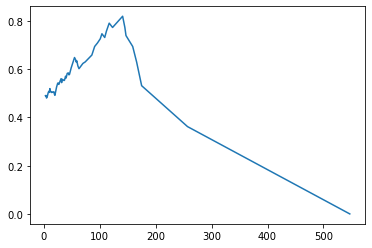

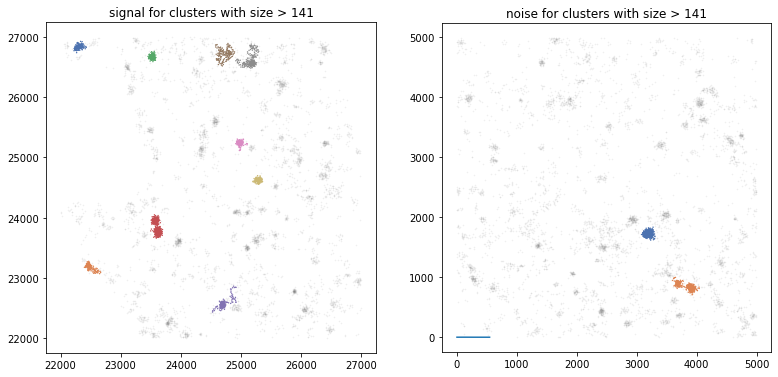

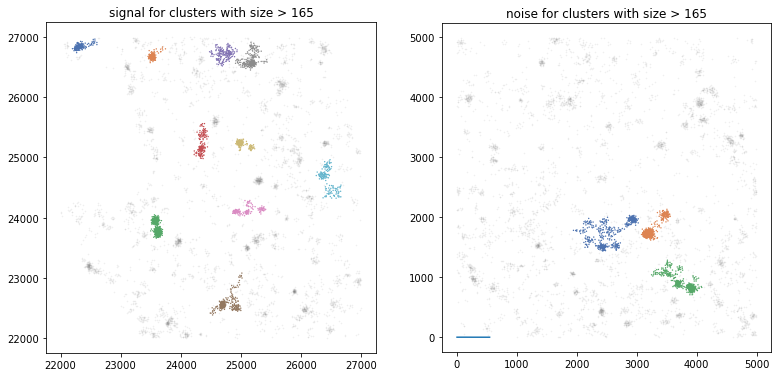

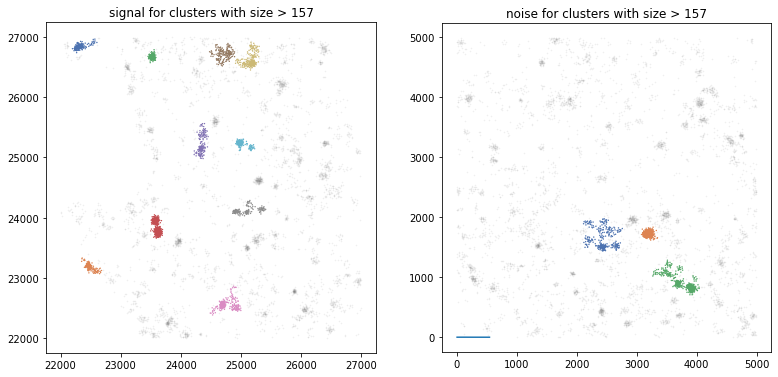

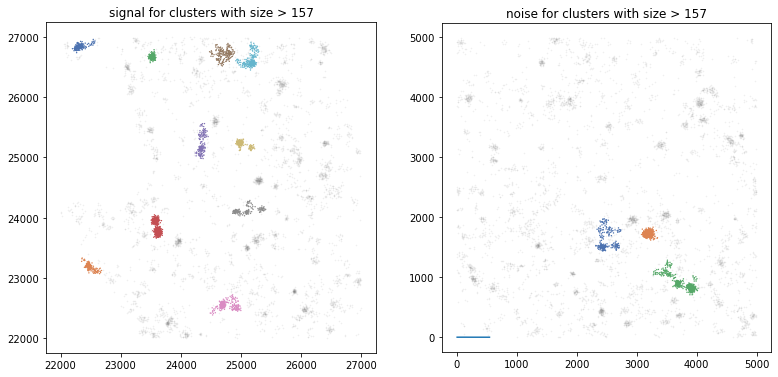

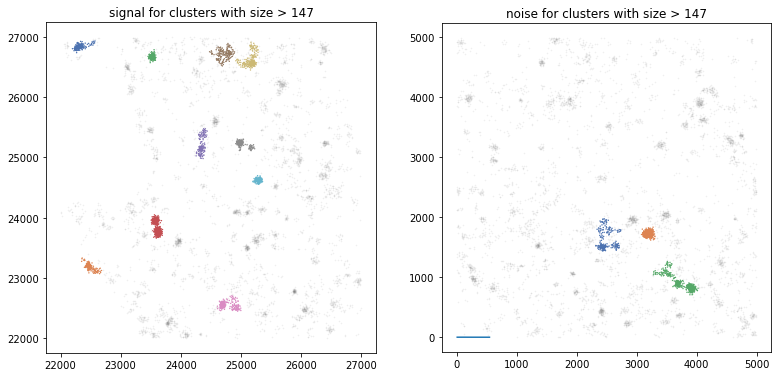

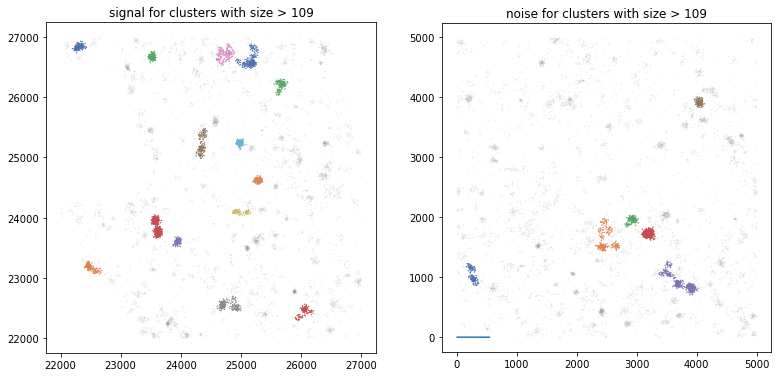

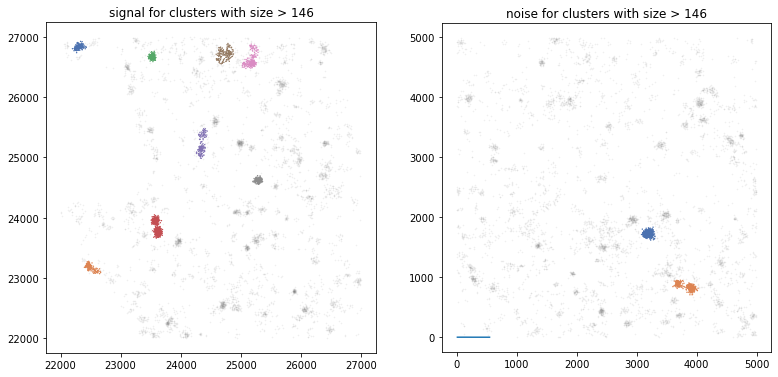

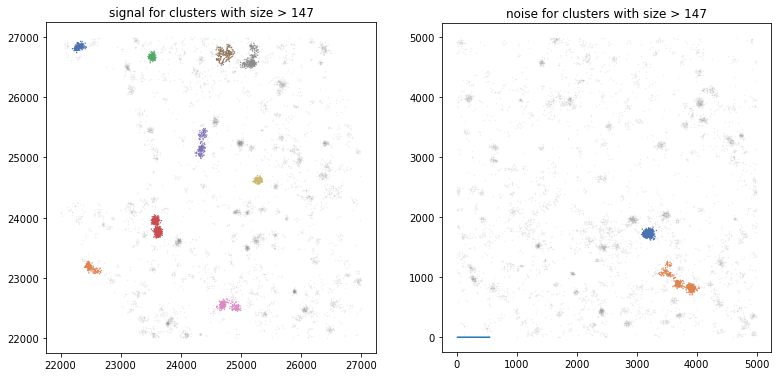

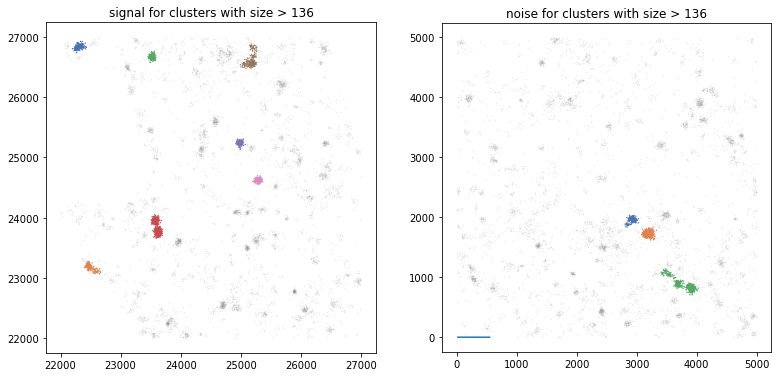

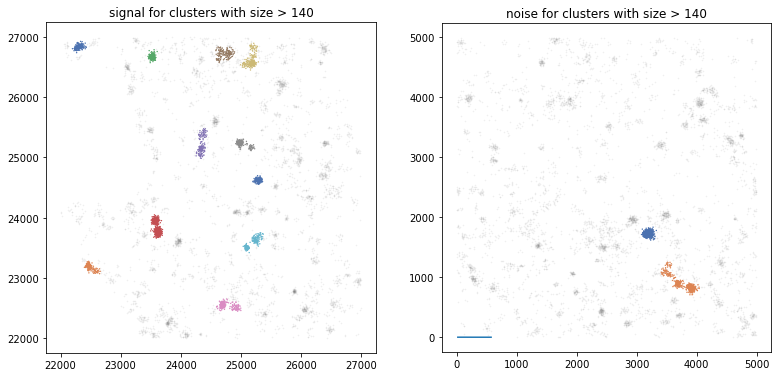

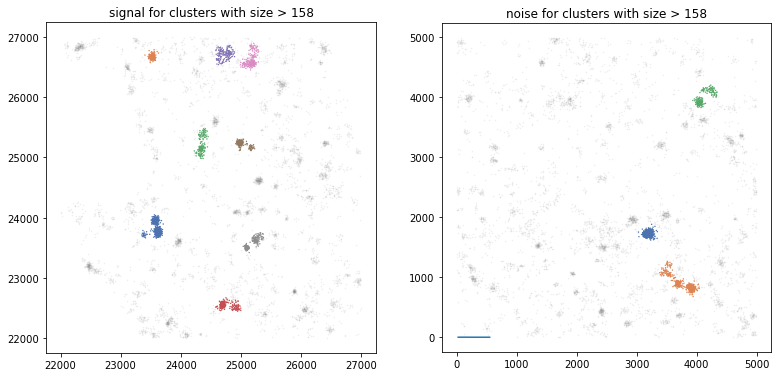

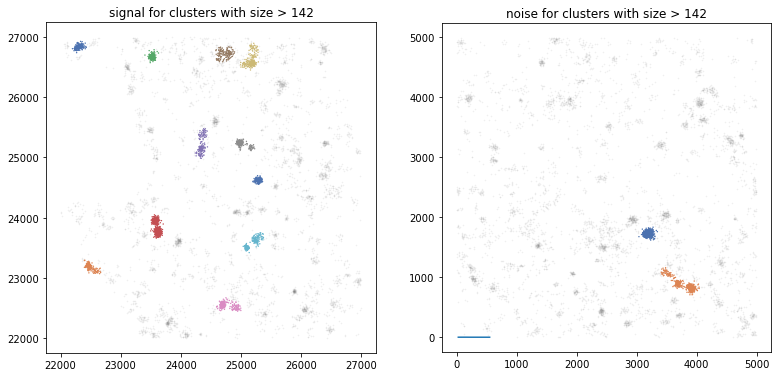

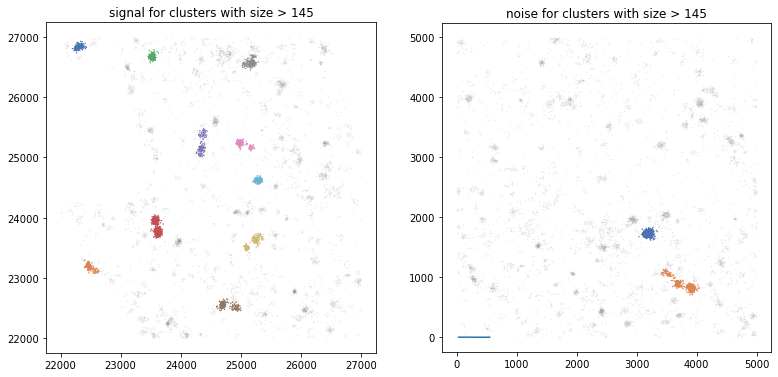

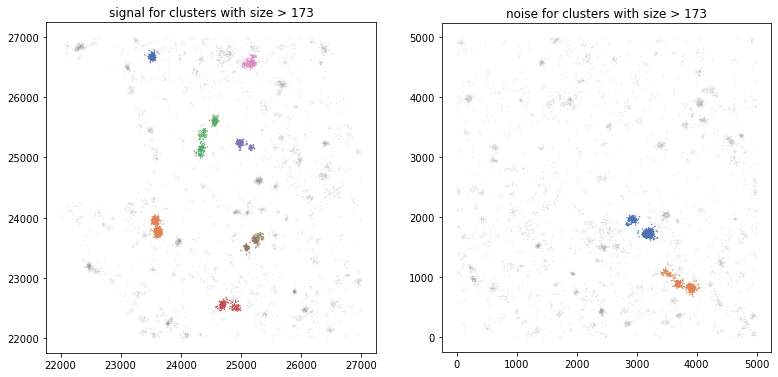

In [96]:
for th in np.unique(df_opt_th['threshold']):
    FindAndPlot(th,df_clusterSizes_all,df_opt_th)

In [ ]:
sns.displot(data=df_clusterSizes_all[df_clusterSizes_all['threshold']==11], x="clusterSize",hue='type')

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import nbinom

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)
    
def fit_function_nb(k,n,p):
    '''poisson function, parameter lamb is the fit parameter'''
    return nbinom.pmf(k, n,p)
    
    
def GetPoissonParameters(data):
    # the bins should be of integer width, because poisson is an integer distribution
    bins = np.round(np.linspace(0,100,20));#np.arange(100) - 0.5
    entries, bin_edges, patches = plt.hist(data, bins=bins, density=True, label='Data');

    # calculate bin centres
    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # fit with curve_fit
    parameters, cov_matrix = curve_fit(fit_function_nb, bin_middles, entries)
    return parameters;

In [ ]:
x_plot = np.arange(600)
np.sum(x_plot*fit_function_nb(x_plot,r,1-p))


In [ ]:
data_max = 200;

mark = (df_clusterSizes_all['threshold']==11)*(df_clusterSizes_all['type']=='noise')
data = np.array(df_clusterSizes_all.loc[mark,'clusterSize'])

data = data[data < data_max]

E,V = np.mean(data),np.var(data);
r = E**2/(V-E);
p = 1-E/V;

print('r :',r,' p: ',p);

# plot poisson-deviation with fitted parameter
bins = np.round(np.linspace(1,data_max,20));#np.arange(100) - 0.5
x_plot = np.round(np.linspace(1,data_max,20));#np.arange(100);

plt.hist(data, bins=bins, density=True, label='Data');
plt.plot(
    x_plot,
    fit_function_nb(x_plot,r,1-p),
    marker='o', linestyle='',
    label='Fit result',
)
plt.legend()
plt.show()

In [ ]:
# the bins should be of integer width, because poisson is an integer distribution
bins = np.round(np.linspace(1,100,20));#np.arange(100) - 0.5
entries, bin_edges, patches = plt.hist(data, bins=bins, density=True, label='Data');

# calculate bin centres
bin_middles = np.round(0.5 * (bin_edges[1:] + bin_edges[:-1]))

# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function_nb, bin_middles, entries)

In [ ]:
cov_matrix

In [ ]:
data

bins = np.linspace(0,100,20);
entries, bin_edges, patches = plt.hist(data, bins=bins, density=True);



In [ ]:
# get poisson deviated random numbers
#data = np.random.poisson(2, 1000)
mark = (df_clusterSizes_all['threshold']==11)*(df_clusterSizes_all['type']=='signal')
data = np.array(df_clusterSizes_all.loc[mark,'clusterSize'])
parameters = GetPoissonParameters(data)
print(parameters)

# plot poisson-deviation with fitted parameter
x_plot = np.round(np.linspace(1,100,20));#np.arange(100);

plt.plot(
    x_plot,
    fit_function_nb(x_plot,10,0.3),
    marker='o', linestyle='',
    label='Fit result',
)
plt.legend()
plt.show()

In [ ]:
df_clusterSizes_all.query('clusterSize < 100')

In [ ]:
df_clusterSizes_all.query('clusterSize < 100').groupby(by=['threshold','type']).agg(['mean','std'])

In [ ]:
df_clusterSizes_all

In [ ]:
(df_clusterSizes['type']).unique()

In [ ]:
df_stats_per_th = AnalyseClusterSizes(df_clusterSizes,df_clusterSizes_ref,save_name+"_phasespace_alongLineOfOptima.pdf");

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
sns.lineplot(data=df_stats_per_th,x='threshold',y='quantile_90',hue='type',ax=axs[0]);
sns.lineplot(data=df_stats_per_th,x='threshold',y='n',hue='type',ax=axs[1]);

In [ ]:
for th in np.unique(df_opt_th['threshold']):
    idx_ = int(df_opt_th.loc[df_opt_th['threshold']==th,'idx'])

    fig,axs = plt.subplots(1,2,figsize=(13,8)); 
    PlotScatter(XC_signal,FD.phasespace.loc[idx_,'labels'],ax=axs[0])
    PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_,'labels'],ax=axs[1])
    axs[0].set_title('signal');
    axs[1].set_title('noise');
    
    axs[1].set_ylim([50,70]);
    axs[1].set_xlim([50,70]);
    plt.savefig(save_name+"_OptimalClustering_threshold_"+str(th)+".pdf",bbox_inches="tight");

## Analyse signal vs noise

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='similarityScore_ref',y="similarityScore",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
sns.lineplot(data=df_opt_sim,x='similarityScore_ref',y="similarityScore",color='r',ax=ax)
sns.lineplot(data=df_opt_cl,x='similarityScore_ref',y="similarityScore",color='b',ax=ax)
ax.set_title('ordered by similarity score');

ax      = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref',y="no_clusters",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
sns.lineplot(data=df_opt_sim,x='no_clusters_ref',y="no_clusters",ax=ax,color='r')
sns.lineplot(data=df_opt_cl,x='no_clusters_ref',y="no_clusters",ax=ax,color='b')
ax.set_title('ordered by no of clusters');

plt.savefig(save_name+"_phasespace_ordered.pdf",bbox_inches="tight");
#ax.set_xlim(-10,2000);
#ax.set_xlim(0,30);

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='similarityScore_ref_ratio',y="similarityScore",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref_ratio'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref_ratio'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
ax.set_xlim(0,1);
#ax.set_ylim(-10,4000);

ax = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref_ratio',y="no_clusters",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref_ratio'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref_ratio'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
ax.set_xlim(0,0.5);

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='no_clusters_ref',y="similarityScore",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
#ax.set_xlim(-10,2000);
#ax.set_ylim(-10,4000);

ax = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref',y="no_clusters",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
#ax.set_xlim(-1,20);
#ax.set_ylim(-1,50);

# Save for input in R 

In [ ]:
#Save phasespace in csv
FD_all1 = (FD.phasespace);
FD_all1['type'] = 'signal';

FD_all2         = (FD_ref.phasespace);
FD_all2['type'] = 'noise';

(FD_all1.append(FD_all2,ignore_index=True)).to_csv(outputfolder_R+'results_'+analysis_name+'.csv');
#(FD.phasespace).to_csv(outputfolder+'results_phasespace'+analysis_name+'.csv');

In [ ]:
L = np.zeros((len((FD.phasespace).loc[1,'labels']),len(FD.phasespace)),dtype=np.int32)
for i,d in enumerate(FD.phasespace['labels']):
    L[:,i] = d;
np.savetxt(outputfolder_R+analysis_name+"_labels_signal.txt",L,fmt="%d",delimiter='\t',newline='\n');    

In [ ]:
L = np.zeros((len((FD_ref.phasespace).loc[1,'labels']),len(FD_ref.phasespace)),dtype=np.int32)
for i,d in enumerate(FD_ref.phasespace['labels']):
    L[:,i] = d;
np.savetxt(outputfolder_R+analysis_name+"_labels_noise.txt",L,fmt="%d",delimiter='\t',newline='\n');    

In [ ]:
np.savetxt(outputfolder_R+analysis_name+"_filtered_noise.txt",XC_noise,fmt="%f\t%f");
np.savetxt(outputfolder_R+analysis_name+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");    

In [ ]:
cls_distribution = [];
ind = np.zeros((0,),dtype=int);
for i,d in enumerate(FD.phasespace['labels']):
    d_ = GetClusterDistribution(d);
    cls_distribution += (d_);
    ind = np.concatenate((ind,i*np.ones_like(d_,dtype=int)))
    
cls_d = pd.DataFrame();
cls_d['size'] = cls_distribution
cls_d['index'] = (ind);
cls_d.to_csv(outputfolder_R+analysis_name+"_clusterSizes.txt")

In [ ]:
#with open(outputfolder_R+analysis_name+"_clusterSizes.txt", "w") as txt_file:
#    for i,d in enumerate(FD.phasespace['labels']):
#        d_ = GetClusterDistribution(d);
#        txt_file.write(' '.join(str(x) for x in d_)+'\n') # works with any number of el

# Analysis

In [ ]:
#Select a clustering:
if(False):
    limit_noise_to_signal = 0.4;
    
    # (1) based on number of clusters
    mark_ = (df1['similarityScore_ref_ratio'] < limit_noise_to_signal);
    idx_similarityScore  = (df1.loc[mark_,'similarityScore']).idxmax();
#    print(df1.loc[idx_similarityScore,:])

    # (1) based on number of clusters
    mark_ = (df1['no_clusters_ref_ratio'] < limit_noise_to_signal);
    idx_no_clusters  = (df1.loc[mark_,'no_clusters']).idxmax();
#    print(df1.loc[idx_no_clusters,:])
else:
    limit_noise_no_cluster = 4;    
    limit_noise_similarity = 320;
        
    # (1) based on number of clusters
    mark_ = (df1['similarityScore_ref'] < limit_noise_similarity);
    idx_similarityScore  = (df1.loc[mark_,'similarityScore']).idxmax();
#    print(df1.loc[idx_similarityScore,:])

    # (1) based on number of clusters
    mark_ = (df1['no_clusters_ref'] < limit_noise_no_cluster);
    idx_no_clusters  = (df1.loc[mark_,'no_clusters']).idxmax();
#    print(df1.loc[idx_no_clusters,:])

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(13,13)); 
PlotScatter(XC_signal,FD.phasespace.loc[idx_similarityScore,'labels'],ax=axs[0,0])
PlotScatter(XC_signal,FD.phasespace.loc[idx_no_clusters,'labels'],ax=axs[0,1])

PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_similarityScore,'labels'],ax=axs[1,0])
PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_no_clusters,'labels'],ax=axs[1,1])

In [ ]:
# Analysis: Did we reach a plateau?
def Plateau_analysis(x,y):    
    x =np.asarray(x);
    y =np.asarray(y);    
    
    y = 0.5*(y[1:]+y[:-1]);
    x = 0.5*(x[1:]+x[:-1]);    
    
    dydx = (y[1:]-y[:-1])/(x[1:]-x[:-1]);
#    print(dydx)
#    print(y)
    plt.plot(x[1:],dydx/y[0],'r');
#    plt.plot(x,y,'b');

In [ ]:
Plateau_analysis(df_stats_per_th['threshold'],df_stats_per_th['firstBin'])
plt.xlim(0,20)

In [ ]:
z = df_stats_per_th['kurtosis'];
sns.lineplot(df_stats_per_th['threshold'][1:],np.abs(np.asarray(z[1:])-np.asarray(z[:-1])),label='kurtosis');

In [ ]:
np.arange(np.max(df_clusterSizes['threshold']))

In [ ]:
sns.histplot(df_clusterSizes.loc[df_clusterSizes['threshold']==11,'clusterSize'],bins=np.linspace(0,100,101)+0.5)

In [ ]:
plt.plot(df_opt_sim['sigma'],df_opt_sim['threshold']);
sns.scatterplot(x=df_opt_sim['sigma'],y=df_opt_sim['threshold'],hue=df_opt_sim['similarityScore'],s=100);
plt.xlim(np.min(df1['sigma']),np.max(df1['sigma']))
plt.ylim(np.min(df1['threshold']),np.max(df1['threshold']))

In [ ]:
plt.plot(df_opt_cl['sigma'],df_opt_cl['threshold']);
sns.scatterplot(x=df_opt_cl['sigma'],y=df_opt_cl['threshold'],hue=df_opt_cl['no_clusters'],s=100);
plt.xlim(np.min(df1['sigma']),np.max(df1['sigma']))
plt.ylim(np.min(df1['threshold']),np.max(df1['threshold']))

In [ ]:
df1['no_clusters_diff'] = np.asarray(df1.loc[:,'no_clusters'])-np.asarray(df1_ref.loc[:,'no_clusters'])
df1 = df1.fillna(0)

fig,axs = plt.subplots(1,2,figsize=(12,5));

heatmap1_data = pd.pivot_table(df1, values='no_clusters_diff', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1]);
ax.invert_yaxis()

In [ ]:
for th in np.unique(FD.phasespace['threshold']):
    mark = (FD.phasespace['threshold'] == th);
    PS_sel = FD.phasespace.loc[mark,:];
    idx_max = PS_sel['similarityScore'].idxmax();
    PlotScatter(XC_signal,PS_sel.loc[idx_max,'labels']);#,str(th));

In [ ]:
PS_sel.loc[:,'labels']

# Experiment

In [ ]:
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))

In [ ]:
def GetCLDist(th):
    data = df_clusterSizes[df_clusterSizes['threshold']==th].loc[:,'clusterSize'];
    bin_no = (np.histogram(data, bins)[0])/np.sum(np.histogram(data, bins)[0]);
    return bin_no;

In [ ]:
GetCLDist(3)

In [ ]:
bins = np.linspace(0,50,11)

In [ ]:
bins

In [ ]:
np.histogram(data, bins,weights=data)[0]

In [ ]:
kl_divergence(GetCLDist(3),GetCLDist(9))

In [ ]:
np.log2(2)

In [ ]:
np.sum(mark)